### CSCI E-82  Homework 5 on CNNs

### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.


## Your Name: Aniket Shah

## Dataset

WikiArt is an amazing resource containing centuries of artwork.  Since such datasets are wonderful for deep learning, Kaggle has hosted a challenge to characterize the 'fingerprints' of various artists.  The Kaggle dataset contains metadata and also a set of images that have been resized so that the shorter dimension is 256 pixels.  To make this homework reasonably fast even for those without GPUs, we have further reduced the images to 64 x 64.  CNNs and neural networks in general prefer to have consistent sizes.  To achieve this, we cut the center 256 pixels from the longer dimension and then shrunk the images by a factor of 4. This isn't a perfect solution since it did cut off a few heads as you will see.

The selected images are for portraits and landscapes.  No, we're not talking about the orientation but rather the content of the images. Thanks to help from Rashmi and Dave, we have a small enough data set that should give reasonable results in a timely manner even on just a CPU.

The data were originally divided into a training and a test set.  We have further divided the training set into a train and validation set.  In this homework you will be using the training set and validation set to train and assess your deep learning models.  At the final step, you will see how well your final training worked on the test set.  In each of these directories, there is a truth.txt file that has the image name and whether it is a portrait or landscape scene.

In [1]:
import sys
print(sys.version)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 929374998911826510
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3204366336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10378001264241714442
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image


from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

Tensorflow is installed and is version:  1.12.0
Keras is installed and is version:  2.1.6-tf


Using TensorFlow backend.


In [3]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

## Problem 1 (5 points)

Read in and display the first 5 portraits and the first 5 landscapes.  Note, if you are using the OpenCV tools, then the color may be distorted.  The cvtColor() method using cv2.COLOR_BGR2RGB may be useful.  However, it is likely easier to use the generator and plot_strip example from section.

In [4]:
# The path to the directory where the original
# dataset was uncompressed
# original_dataset_dir = './images64'

# base_dir = os.path.join('.', 'portraits_and_landscapes')
# if os.path.exists(base_dir) and os.path.isdir(base_dir):
#     shutil.rmtree(base_dir)

# Directories for our training,
directories = []

# The directory where we will
# store our smaller dataset
base_dir = './portraits_and_landscapes'
directories.append(base_dir)

# validation and test splits
train_dir = os.path.join(base_dir, 'train')
directories.append(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
directories.append(validation_dir)

test_dir = os.path.join(base_dir, 'test')
directories.append(test_dir)

# Directory with our training portrait pictures
train_portraits_dir = os.path.join(train_dir, 'portraits')
directories.append(train_portraits_dir)

# Directory with our training  landscape pictures
train_landscapes_dir = os.path.join(train_dir, 'landscapes')
directories.append(train_landscapes_dir)

# Directory with our validation portrait pictures
validation_portraits_dir = os.path.join(validation_dir, 'portraits')
directories.append(validation_portraits_dir)

# Directory with our validation landscape pictures
validation_landscapes_dir = os.path.join(validation_dir, 'landscapes')
directories.append(validation_landscapes_dir)

# Directory with our test portrait pictures
test_portraits_dir = os.path.join(test_dir, 'portraits')
directories.append(test_portraits_dir)

# Directory with our test landscape pictures
test_landscapes_dir = os.path.join(test_dir, 'landscapes')
directories.append(test_landscapes_dir)

# if they have not already been created
for dir in directories: 
    os.mkdir(dir)

In [6]:

data_dir = os.path.join('.', 'images64')
original_train_dir = os.path.join(data_dir, 'train')
original_validation_dir = os.path.join(data_dir, 'validation')
original_test_dir = os.path.join(data_dir, 'test')

# Split Training Data
df = pd.read_table('./images64/train/truth.txt', delim_whitespace=True, names=('fileName', 'picLabel'))
# Copy portrait images to train_portraits_dir
portraitDF = df.loc[df['picLabel'] == 'portrait']
portraitFiles = [row['fileName'] for index, row in portraitDF.iterrows()]
for pFile in portraitFiles:
    src = os.path.join(original_train_dir, pFile)
    dst = os.path.join(train_portraits_dir, pFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
        
# Copy landscape images to train_landscapes_dir
landscapeDF = df.loc[df['picLabel'] == 'landscape']
landscapeFiles = [row['fileName'] for index, row in landscapeDF.iterrows()]
for lFile in landscapeFiles:
    src = os.path.join(original_train_dir, lFile)
    dst = os.path.join(train_landscapes_dir, lFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
        
# Split Validation Data
df = pd.read_table('./images64/validation/truth.txt', delim_whitespace=True, names=('fileName', 'picLabel'))
# Copy portrait images to validation_portraits_dir
portraitDF = df.loc[df['picLabel'] == 'portrait']
portraitFiles = [row['fileName'] for index, row in portraitDF.iterrows()]
for pFile in portraitFiles:
    src = os.path.join(original_validation_dir, pFile)
    dst = os.path.join(validation_portraits_dir, pFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
        
# Copy landscape images to validation_landscapes_dir
landscapeDF = df.loc[df['picLabel'] == 'landscape']
landscapeFiles = [row['fileName'] for index, row in landscapeDF.iterrows()]
for lFile in landscapeFiles:
    src = os.path.join(original_validation_dir, lFile)
    dst = os.path.join(validation_landscapes_dir, lFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
        
# Split Test Data
df = pd.read_table('./images64/test/truth.txt', delim_whitespace=True, names=('fileName', 'picLabel'))
# Copy portrait images to test_portraits_dir
portraitDF = df.loc[df['picLabel'] == 'portrait']
portraitFiles = [row['fileName'] for index, row in portraitDF.iterrows()]
for pFile in portraitFiles:
    src = os.path.join(original_test_dir, pFile)
    dst = os.path.join(test_portraits_dir, pFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)
        
# Copy landscape images to test_landscapes_dir
landscapeDF = df.loc[df['picLabel'] == 'landscape']
landscapeFiles = [row['fileName'] for index, row in landscapeDF.iterrows()]
for lFile in landscapeFiles:
    src = os.path.join(original_test_dir, lFile)
    dst = os.path.join(test_landscapes_dir, lFile)
    if os.path.getsize(src) > 0:
        shutil.copyfile(src, dst)

In [7]:
for dir in directories[4:]:
    print("\nImages in " + dir + ":" + str(len(os.listdir(dir))))


Images in ./portraits_and_landscapes\train\portraits:8692

Images in ./portraits_and_landscapes\train\landscapes:7623

Images in ./portraits_and_landscapes\validation\portraits:4233

Images in ./portraits_and_landscapes\validation\landscapes:3925

Images in ./portraits_and_landscapes\test\portraits:3921

Images in ./portraits_and_landscapes\test\landscapes:3458


In [167]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# generator for the validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

# generator for the test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=32,  # this just makes sure it gets through memory
        class_mode='binary')

Found 16315 images belonging to 2 classes.
Found 8158 images belonging to 2 classes.
Found 7379 images belonging to 2 classes.


In [136]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


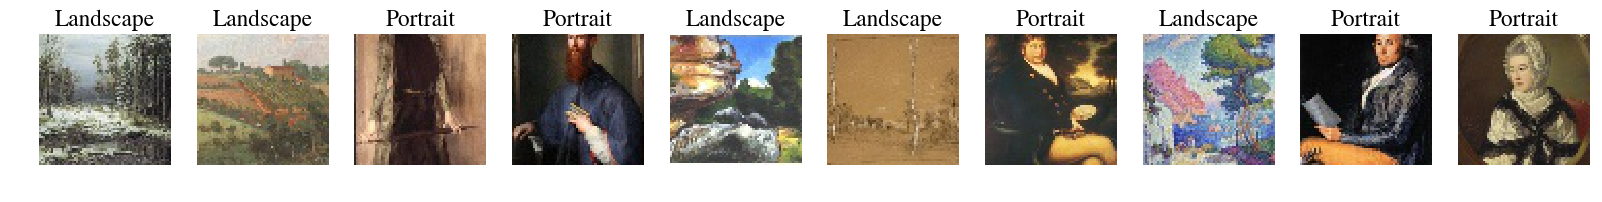

In [137]:
def plot_strip(data, labels):
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    f, ax = plt.subplots(nrows=1, ncols=10)
    
    portraitNum = 0
    landscapeNum = 0
    sumNum = landscapeNum + portraitNum
    arr =[]
    
    #Adding 5 portraits and landscapes 
    for i in range(labels.shape[0]):
        if(int(labels[i]) == 0 and landscapeNum <5):
            arr.append(i)
            landscapeNum+=1
        if(int(labels[i]) == 1 and portraitNum < 5):
            arr.append(i)
            portraitNum+=1
    #Displaying The portraits
    for i, j in enumerate(np.array(arr)):
        ax[i].axis('off')
        ax[i].set_title(['Landscape','Portrait'][int(labels[j])], loc='center')
        ax[i].imshow(data[j,:,:], cmap='gray')

        
plot_strip(data_batch, labels_batch)

## Problem 2 (25 points)

Construct a baseline CNN classifier using Keras for the training set and assess the validation set performance at each epoch. The goal is to correctly classify portraits from landscapes. Plot the resulting performance on the training and validation set as a function of epoch using the criteria over which you are optimizing.  You should run at least 20 epochs for this problem.

In [138]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='.\logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [12]:
K.clear_session()

model = models.Sequential(name='baselineCNN')
#First Convolution Layer
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                        name = 'conv1', input_shape=data_batch.shape[1:]))
#Max Pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool1'))

# Second Convolution Later and max pooling
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                        name = 'conv2', input_shape=data_batch.shape[1:]))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool2'))

#Flatten the layers
model.add(layers.Flatten())
#Relu activation
model.add(layers.Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
#Sigmoid activation for binary classification
model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

#Optimizer
sgd = optimizers.SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              16778240  
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 1025      
Total para

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs\{}".format(time()), write_graph=True)])

test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

Epoch 1/20
100/100 [==============================] - 7s 68ms/step - loss: 0.6659 - acc: 0.6238 - val_loss: 0.5276 - val_acc: 0.7712
Epoch 2/20
100/100 [==============================] - 5s 53ms/step - loss: 0.5163 - acc: 0.7631 - val_loss: 0.4637 - val_acc: 0.7900
Epoch 3/20
100/100 [==============================] - 5s 53ms/step - loss: 0.5138 - acc: 0.7578 - val_loss: 0.4664 - val_acc: 0.7875
Epoch 4/20
100/100 [==============================] - 5s 53ms/step - loss: 0.4762 - acc: 0.7806 - val_loss: 0.4609 - val_acc: 0.7850- lo
Epoch 5/20
100/100 [==============================] - 5s 53ms/step - loss: 0.4807 - acc: 0.7816 - val_loss: 0.4880 - val_acc: 0.7725
Epoch 6/20
100/100 [==============================] - 5s 54ms/step - loss: 0.4067 - acc: 0.8102 - val_loss: 0.3115 - val_acc: 0.8773: 2s
Epoch 7/20
100/100 [==============================] - 5s 53ms/step - loss: 0.3554 - acc: 0.8400 - val_loss: 0.3475 - val_acc: 0.8619
Epoch 8/20
100/100 [==============================] - 5s 53ms

![baselineCNN](baselineCNN.jpg)

## Problem 3 (5 points)

From the pattern of training and validation curves, describe what is good/bad and what you plan to do next to improve the result.

For the baseline mode, I applied the same model as what was applied in step 2 of section, and got decent results with a test accuracy of 0.896. Looking at the plots on tensorboard, I can see that the training and validation errors move in sync till about 0.90, and then training increases, but validation error decreases a bit, indicating slight overfitting might be occuring. I will look to do batch normalization and add regularization using dropout. But before that I will look to add capacity by increasing the number of layers, and see if it improves test accuracy.

## Problem 4 (45 points)

This step is where we want you to do most of your personal learning.  Your goal is to improve the network using a combination of architecture choices, parameter tuning, and experimenting with different optimizers/dropout/regularization/etc. Treat each of these as separate optimization/exploration steps for now.  We would like to see 3 separate steps that cover different areas.  The format of the 3 steps should be as follows:
  * State the hypothesis/strategy for how you will improve/explore a particular aspect.
  * Describe what types of tests you are running and why (i.e. what range of parameters are you choosing and why)
  * Include the code and results
  * State your interpretation of the results
 
We're not looking for research in deep learning, but we want you to gain some hands-on experience working with Keras and figuring out what works. A good example may be comparing strategies to overcome overfitting, or comparing a few different CNN architectures in terms of performance and speed, or comparing data augmentation types and results.  
 


### Capacity Increase
I have increased the capacity here, by adding another layer of convolution and max pooling. To avoid a reduction in the number of trained parameters, I also increased the number of filters, starting from 64 and increasing to 256. 

In [24]:
K.clear_session()
def threeConvLay_model_paintings():
    model = Sequential()
    #First Convolution Layer
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv1', input_shape=data_batch.shape[1:]))
    #Max Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool1'))

    # Second Convolution Later and max pooling
    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv2', input_shape=data_batch.shape[1:]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool2'))

    # Third Convolution Later and max pooling
    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv3', input_shape=data_batch.shape[1:]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool3'))


    #Flatten the layers
    model.add(layers.Flatten())
    #Relu activation
    model.add(layers.Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    #Sigmoid activation for binary classification
    model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

    #Optimizer
    sgd = optimizers.SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    # model.compile(loss='binary_crossentropy',
    #                   optimizer=optimizers.RMSprop(lr=1e-4),
    #                   metrics=['acc'])
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
threeConvMod = threeConvLay_model_paintings()
threeConvMod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [25]:
history = threeConvMod.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs\{}".format(time()), write_graph=True)])

test_loss, test_acc = threeConvMod.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

Epoch 1/20
100/100 [==============================] - 10s 100ms/step - loss: 0.6528 - acc: 0.6338 - val_loss: 0.4884 - val_acc: 0.7887
Epoch 2/20
100/100 [==============================] - 10s 99ms/step - loss: 0.4587 - acc: 0.7916 - val_loss: 0.3920 - val_acc: 0.8173
Epoch 3/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3699 - acc: 0.8238 - val_loss: 0.3493 - val_acc: 0.8444
Epoch 4/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3591 - acc: 0.8406 - val_loss: 0.4130 - val_acc: 0.7944
Epoch 5/20
100/100 [==============================] - 9s 93ms/step - loss: 0.3356 - acc: 0.8541 - val_loss: 0.3418 - val_acc: 0.8269
Epoch 6/20
100/100 [==============================] - 9s 93ms/step - loss: 0.2926 - acc: 0.8741 - val_loss: 0.2840 - val_acc: 0.8919
Epoch 7/20
100/100 [==============================] - 9s 93ms/step - loss: 0.2736 - acc: 0.8902 - val_loss: 0.3126 - val_acc: 0.8636
Epoch 8/20
100/100 [==============================] - 9s 93ms/step

![threeCNN](baselineCNNincreasCap.jpg)

The plots show that the validation accuracy, and training accuracy diverge more and the testing accuracy also decreases to 0.873 from 0.896, suggesting overfitting. 

### Dropout
In this model, I add dropout to the last two convolutional layers and the dense fully connected layer. This is an effort to reduce overfitting and hopefully, increase test error.

In [168]:
K.clear_session()
def dropout_model_paintings():
    
    model = Sequential(name='baselineCNNDropout')
    #First Convolution Layer
    model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv1', input_shape=data_batch.shape[1:]))
    #Max Pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool1'))

    # Second Convolution Later and max pooling
    model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv2', input_shape=data_batch.shape[1:]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool2'))
    model.add(Dropout(rate=0.4))

    # Third Convolution Later and max pooling
    model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides = (1, 1), padding='same', activation='relu', 
                            name = 'conv3', input_shape=data_batch.shape[1:]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name='max_pool3'))
    model.add(Dropout(rate=0.4))


    #Flatten the layers
    model.add(layers.Flatten())
    #Relu activation
    model.add(layers.Dense(1024, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dropout(rate=0.4))
    #Sigmoid activation for binary classification
    model.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid', name='fc2'))

    #Optimizer
    sgd = optimizers.SGD(lr = 0.05, decay=1e-6, momentum=0.9, nesterov=True)

    # model.compile(loss='binary_crossentropy',
    #                   optimizer=optimizers.RMSprop(lr=1e-4),
    #                   metrics=['acc'])
    model.compile(Adam(lr=0.001),loss="binary_crossentropy", metrics=["accuracy"])
    return model

dropoutMod = dropout_model_paintings()
dropoutMod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 8, 8, 256)         0         
__________

In [169]:
history = dropoutMod.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=100,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs\{}".format(time()), write_graph=True)])

test_loss, test_acc = dropoutMod.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

Epoch 1/20
200/200 [==============================] - 24s 118ms/step - loss: 0.4795 - acc: 0.7616 - val_loss: 0.3334 - val_acc: 0.8569
Epoch 2/20
200/200 [==============================] - 23s 116ms/step - loss: 0.3221 - acc: 0.8636 - val_loss: 0.2648 - val_acc: 0.8959
Epoch 3/20
200/200 [==============================] - 23s 116ms/step - loss: 0.2538 - acc: 0.8986 - val_loss: 0.2770 - val_acc: 0.8821
Epoch 4/20
200/200 [==============================] - 23s 116ms/step - loss: 0.2446 - acc: 0.9019 - val_loss: 0.2248 - val_acc: 0.9041
Epoch 5/20
200/200 [==============================] - 23s 116ms/step - loss: 0.2256 - acc: 0.9078 - val_loss: 0.2351 - val_acc: 0.9006
Epoch 6/20
200/200 [==============================] - 23s 116ms/step - loss: 0.2092 - acc: 0.9125 - val_loss: 0.2042 - val_acc: 0.9146
Epoch 7/20
200/200 [==============================] - 23s 116ms/step - loss: 0.2044 - acc: 0.9166 - val_loss: 0.1722 - val_acc: 0.9316
Epoch 8/20
200/200 [==============================] - 2

![Dropout](CNNdropout.jpg)

After adding dropout, with the SGD optimizer, it performed terribly (an accuracy below 0.50), but when along with dropout, the optimizer was changed to Adam's optimizer, the validation and training accuracy converged to 0.93. The testing accuracy also went up from a previous best of 0.895 to 0.931. I also increased the number of steps per epoch from 100 to 200, and hence that also contributed in taking the accuracy up to 0.931 (without the increase in number of steps, test accuracy was 0.920). 

### AlexNet Model
In this model, I keep a structure similar to the original AlexNet model but given the reduced size of the images at 64 x 64, I reduce the number of filters and kernel size for every step. For max pooling, I reduce the pool size to 2 and strides to 1 therefore, still keeping the overlap. I reduce the number of weights in the dense layer, and also add l2 regularization to the weights in the dense layer.

In [139]:
# An AlexNet network architecture
K.clear_session()
from keras import regularizers
def alex_model_paintings():
    # (3) Create a sequential model
    model = Sequential()

    # 1st Convolutional Layer -> reduced kernel size and strides
    model.add(Conv2D(filters=32, input_shape=data_batch.shape[1:], kernel_size=(5,5),\
     strides=(2,2), padding='same'))
    model.add(Activation('relu'))
    # Pooling -> reduced pool size, and stride, but still kept the concept of overlap as in AlexNet
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer -> reduced kernel_size
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # High number of filters, but no pooling in these layers
    # 3rd Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(1024,kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(1024, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(250, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Activation('sigmoid'))


    # (4) Compile 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model 

alexNetMod = alex_model_paintings()
alexNetMod.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
__________

In [140]:
# Fit model
history = alexNetMod.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=100,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs\{}".format(time()), write_graph=True)])

test_loss, test_acc = alexNetMod.evaluate_generator(test_generator, steps=100)
print('\ntest accuracy:', test_acc)
print('test loss:', test_loss)

Epoch 1/20
200/200 [==============================] - 57s 286ms/step - loss: 2.5065 - acc: 0.8420 - val_loss: 1.9722 - val_acc: 0.8575
Epoch 2/20
200/200 [==============================] - 50s 252ms/step - loss: 1.4829 - acc: 0.8852 - val_loss: 1.2066 - val_acc: 0.8672
Epoch 3/20
200/200 [==============================] - 50s 252ms/step - loss: 1.0053 - acc: 0.8911 - val_loss: 0.9524 - val_acc: 0.8615
Epoch 4/20
200/200 [==============================] - 51s 253ms/step - loss: 0.8122 - acc: 0.8978 - val_loss: 1.7910 - val_acc: 0.6872
Epoch 5/20
200/200 [==============================] - 50s 252ms/step - loss: 0.6863 - acc: 0.8944 - val_loss: 0.5932 - val_acc: 0.9041
Epoch 6/20
200/200 [==============================] - 50s 252ms/step - loss: 0.5847 - acc: 0.8986 - val_loss: 0.6338 - val_acc: 0.8599
Epoch 7/20
200/200 [==============================] - 50s 252ms/step - loss: 0.5364 - acc: 0.9034 - val_loss: 0.4894 - val_acc: 0.9122
Epoch 8/20
200/200 [==============================] - 5

![alexNet](CNNalexNet1.jpg)

The alex net model does provide a test accuracy of 0.927, but the training and validations accuracies have very high variance from one epoch to the next. Given the huge number of weights to be trained, this model seems to be overfitting the data. Despite the constant increase in training error, validation error is all over the place. I belive this can be remedied with higher regularization than 0.001, probably somewhere around 0.01 and dropout in convolutional layers as well. 

## Problem 5 (10 points)

Assess your best model on the test data.  Plot the corresponding AUC curve from the results (since we've provided the truth).  This was not directly covered in section, but will require a prediction using images in the same format as the training.  We suggest referring to the Keras API else use a Google to search to find how to make predictions.

In [164]:
test_generator_pred = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        shuffle = False,
        batch_size=40)
#actual class labels
y_test = test_generator_pred.classes[test_generator_pred.index_array]
#Predicting and Converting to binary for alexnet
predictImages = alexNetMod.predict_generator(test_generator_pred, steps=185, verbose = 1)
# predictBinary = [0 if(predictImages[i] < 0.5) else 1 for i in range(0,len(predictImages))]
print(len(predictBinary))

Found 7379 images belonging to 2 classes.
185/185 [==============================] - 6s 31ms/step
7379


In [170]:
#Predicting and Converting to binary for dropout model
test_generator_pred = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        shuffle = False,
        batch_size=40,
        class_mode='binary')
dropoutPredictImages = dropoutMod.predict_generator(test_generator_pred, steps=185, verbose = 1)

Found 7379 images belonging to 2 classes.
185/185 [==============================] - 6s 32ms/step


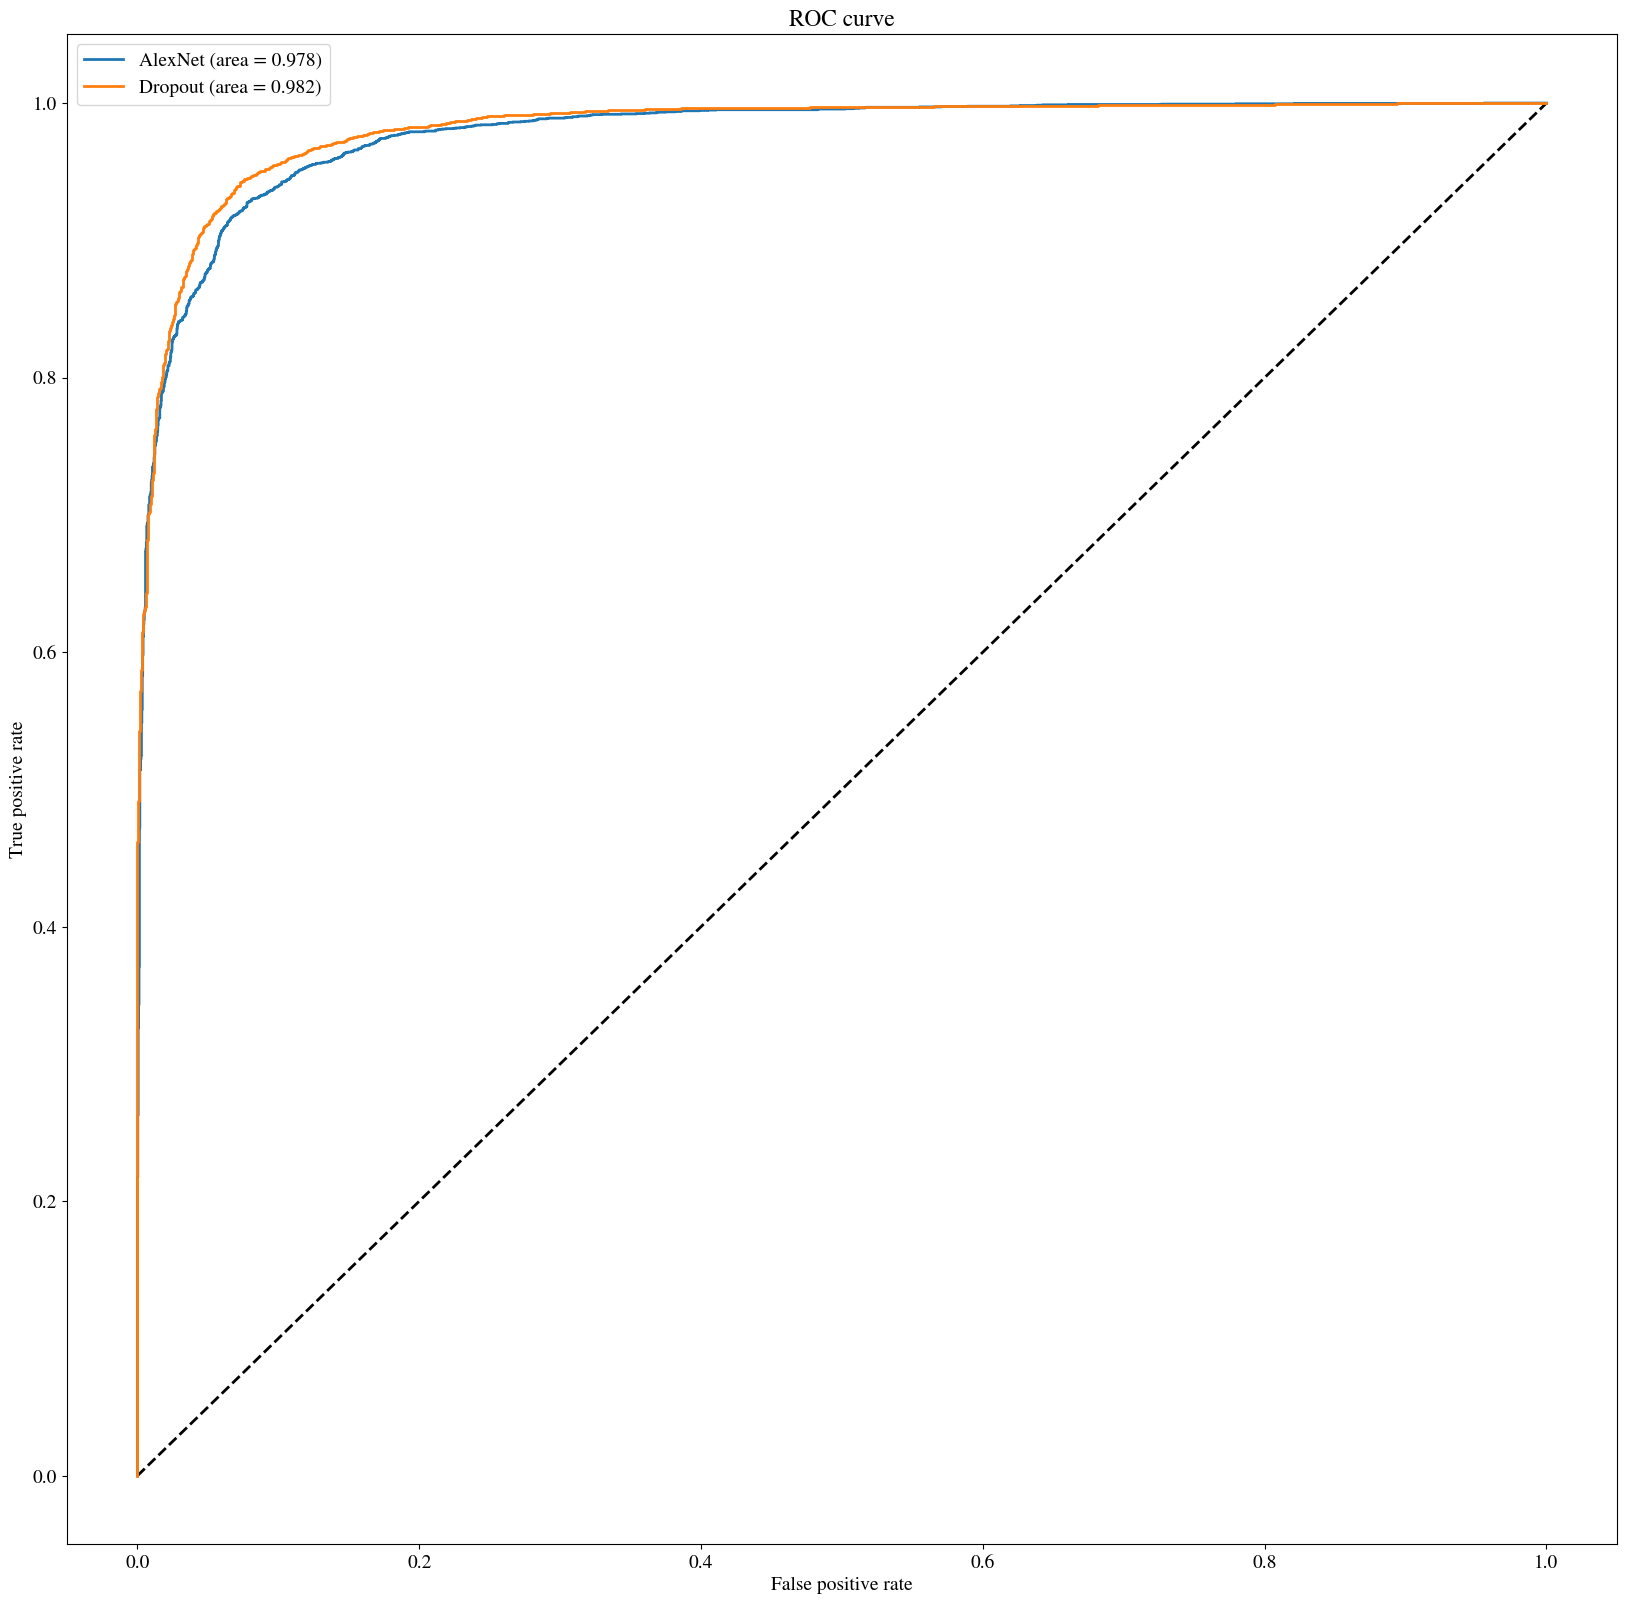

In [171]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
fpr_alexNet, tpr_alexNet, thresholds = roc_curve(y_test.T, predictImages)
fpr_dropout, tpr_dropout, thresholds = roc_curve(y_test.T, dropoutPredictImages)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_alexNet, tpr_alexNet, label='AlexNet (area = {:.3f})'.format(auc(fpr_alexNet, tpr_alexNet)))
plt.plot(fpr_dropout, tpr_dropout, label='Dropout (area = {:.3f})'.format(auc(fpr_dropout, tpr_dropout)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The ROC curves indicate that both AlexNet and Dropout are useful models in classifying the painting. It can be seen above that the AUC of the dropout model is slightly higher than that of the Alexnet model. 

## Problem 6 (5 points)

Display the 5 images [worst] misclassified images for each class.  Worst is in brackets since certain architectures may only make a binary decision rather than a score.  In that case, plot 5 of each.

In [201]:
from os import listdir
from os.path import isfile, join
#Making a list of all portrait files and ordering them numerically
portraitFiles = [f for f in listdir(test_portraits_dir) if isfile(join(test_portraits_dir, f))]
portraitFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#Making a list of all landscape files and ordering them numerically
landscapeFiles = [f for f in listdir(test_landscapes_dir) if isfile(join(test_landscapes_dir, f))]
landscapeFiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [205]:
# Combined list of files with the same order as y_test
allFiles = []
for x in landscapeFiles:
    allFiles.append(x)
for x in portraitFiles:
    allFiles.append(x)

print(len(allFiles))


7379


In [229]:
# Taking the difference keeping in mind landscape is represented by 0, and hence the difference with 
# value closest to one would be the lowest 
diffClass = y_test.T - dropoutPredictImages
sortErrorLandscape = np.argsort(diffClass, axis= 0)
landScapeWorstFiles = [allFiles[sortErrorLandscape[i][0]] for i in range(5)]

# Taking the difference keeping in mind portrait is represented by 1, and hence subtracting 1 from 
# value closest to 0 would be the lowest 
diffClass1 = dropoutPredictImages - y_test.T
sortErrorPortrait = np.argsort(diffClass1, axis= 0)
portraitWorstFiles = [allFiles[sortErrorPortrait[i][0]] for i in range(5)]
print(landScapeWorstFiles)
print(portraitWorstFiles)

['6373.jpg', '97267.jpg', '15081.jpg', '75827.jpg', '60452.jpg']
['95139.jpg', '72967.jpg', '89804.jpg', '31619.jpg', '16173.jpg']


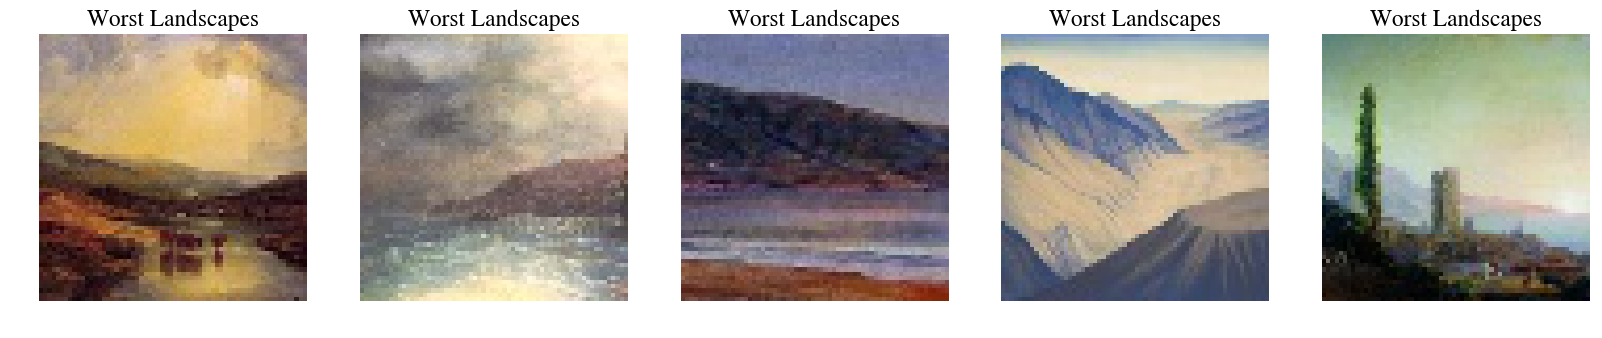

In [232]:
# Plotting the images that were classified as portraits, but were actually landscapes
import matplotlib.image as mpimg
# mpimg.imread('image_name.png')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=5)
for i, j in enumerate(np.asarray(landScapeWorstFiles)):
        ax[i].axis('off')
        ax[i].set_title('Worst Landscapes', loc='center')
        ax[i].imshow(mpimg.imread( './portraits_and_landscapes/test/landscapes/'+ j), cmap='gray')

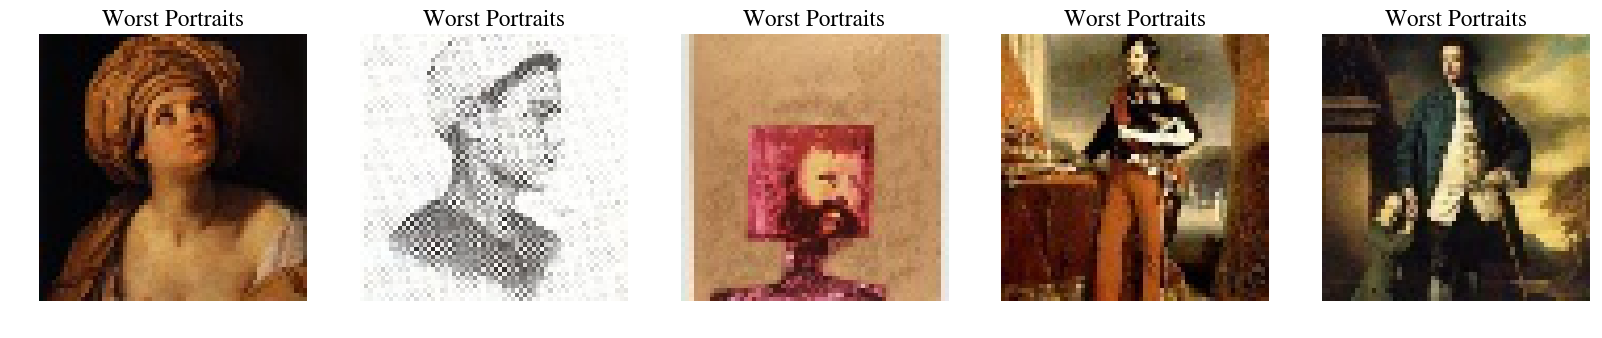

In [233]:
# Plotting the images that were classified as landscapes, but were actually portraits
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=5)
for i, j in enumerate(np.asarray(portraitWorstFiles)):
        ax[i].axis('off')
        ax[i].set_title('Worst Portraits', loc='center')
        ax[i].imshow(mpimg.imread( './portraits_and_landscapes/test/portraits/'+ j), cmap='gray')

## Problem 7 (2 points)
How many hours did this homework take you? The answer to this question will not affect your grade.

8

## Last step (3 points)
Save this notebook as LastnameFirstnameHW5.ipynb such as PriceDavid.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.